In [3]:
# Prophet model for time series forecast
import os
import darts
import prophet
import pyspark

# Data processing
import pandas as pd
import numpy as np
import csv

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Multi-processing
from multiprocessing import Pool, cpu_count

# Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType
from prophet import Prophet

# Process bar
from tqdm import tqdm

# Tracking time
from time import time

#hmm needed? 
import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

#darts
# transformers and preprocessing
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

%matplotlib inline
from tslearn.clustering import silhouette_score
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = [25, 8]

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


import matplotlib.pyplot as plt
from sklearn.cluster import BisectingKMeans
from datetime import datetime



In [20]:
#Data processing
data = pd.read_csv('/work/Data-Science-Liv/Data/life_expectancy.csv')

#Exclude entries that are not countries
exclude = ['Africa', 'Asia', 'Europe', 'High-income countries', 'Land-locked Developing Countries (LLDC)', 'Latin America and the Caribbean','Least developed countries','Less developed regions','Less developed regions, excluding China','Less developed regions, excluding least developed countries', 'Low-income countries','Lower-middle-income countries','More developed regions','Northern America','Oceania','Small Island Developing States (SIDS)','Upper-middle-income countries','World', 'Americas']

#Make datetime
data1['Year'] = pd.to_datetime(data['Year'])

# Subset the DataFrame based on the countries of interest
data_countries = data.loc[~data['Country'].isin(exclude)]

# Rename Life expectancy column
data_countries.rename(columns={'Life expectancy at birth (historical)': 'LE'}, inplace=True)


#Pivot data differently  to preserve individual time series
pivoted_data = data_countries.pivot(index='Country', columns='Year', values='LE')

# Convert the pivot data to a list of time series
time_series = pivoted_data.values.tolist()


NameError: name 'data1' is not defined

In [10]:
#Inspect columns
print(data_countries.columns)

Index(['Country', 'Year', 'LE'], dtype='object')


<AxesSubplot:xlabel='Year', ylabel='LE'>

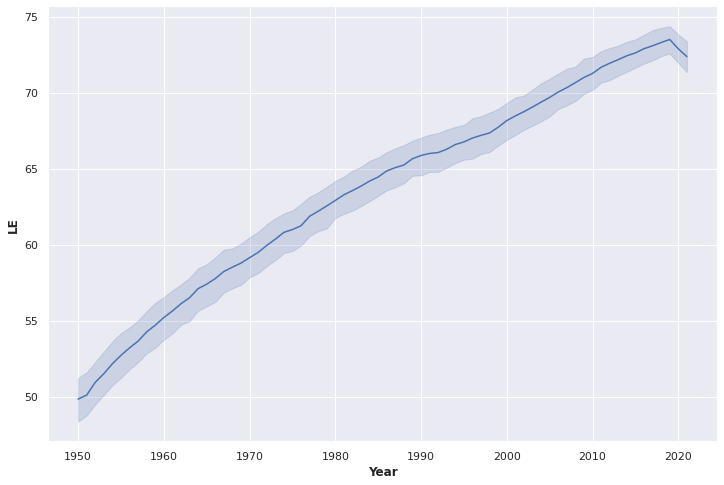

In [11]:
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data_countries['Year'], y=data_countries['LE'])

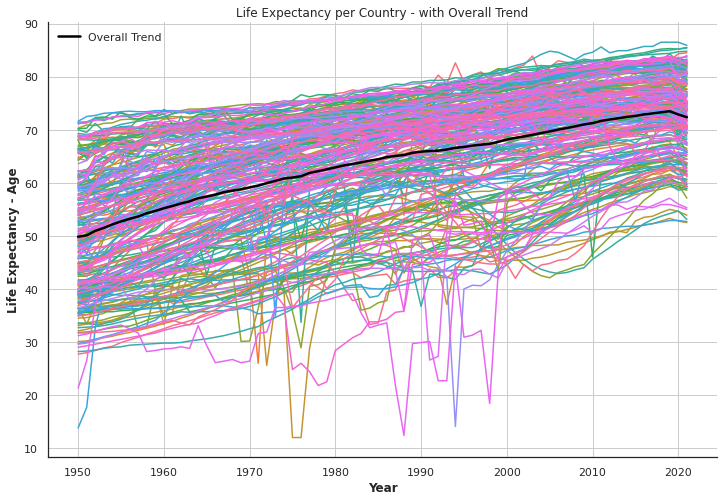

In [12]:
# Set the figure size and background color
sns.set(rc={'figure.figsize': (12, 8)})
sns.set_style("white")  # Set the style to white

# Plotting individual time series per country with overlapping lines and no legend
sns.lineplot(x='Year', y='LE', hue='Country', data=data_countries, legend=False)

# Calculate the overall trend (e.g., average)
overall_trend = data_countries.groupby('Year')['LE'].mean()

# Plot the overall trend line
plt.plot(overall_trend.index, overall_trend, color='black', linestyle='-', lw=2.5, label='Overall Trend')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Life Expectancy - Age')
plt.title('Life Expectancy per Country - with Overall Trend')
plt.grid(True)  
plt.legend()

# Remove the box around the plot
sns.despine()
plt.show()


In [13]:
# Checking unique countries
unique_countries = data_countries['Country'].unique()
print(unique_countries)

['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Anguilla' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia' 'Bonaire Sint Eustatius and Saba' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'British Virgin Islands' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde'
 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Cuba' 'Curacao' 'Cyprus' 'Czechia'
 'Democratic Republic of Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Faeroe Islands'
 'Falkland Islands' 'Fiji' 'Finland' 'France' 'French Guiana'
 'French Polynesia' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana'
 'Gibral

## Creating Clusters

#### Deciding the best number of clusters

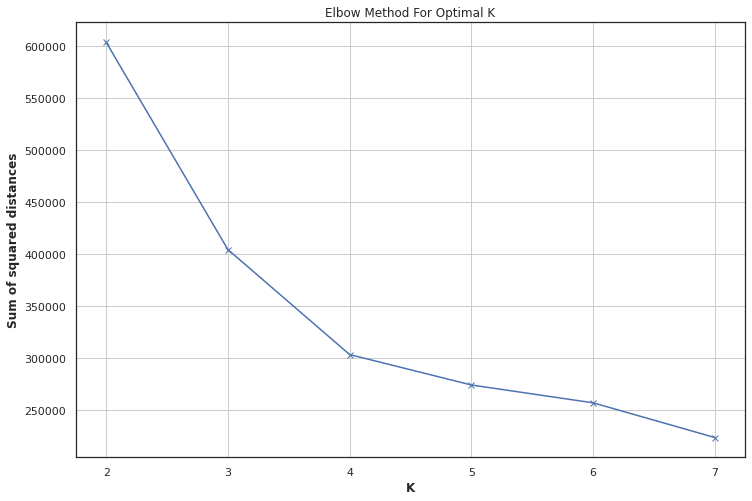

In [18]:
## Deciding how many clusters to use
Sum_of_squared_distances = []
K = range(2,8)
for k in K:
    km = BisectingKMeans(n_clusters=k,
                          n_init=2,
                          verbose=False,
                          bisecting_strategy = "biggest_inertia")
    
    km = km.fit(time_series)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.grid(True)
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal K')
plt.show()

It seems like the optimal number of clusters is 4. After this, the sum of squared distances is not decreasing much as K increases

### Performing the clustering and saving them i long format

In [26]:
import matplotlib.colors as colors

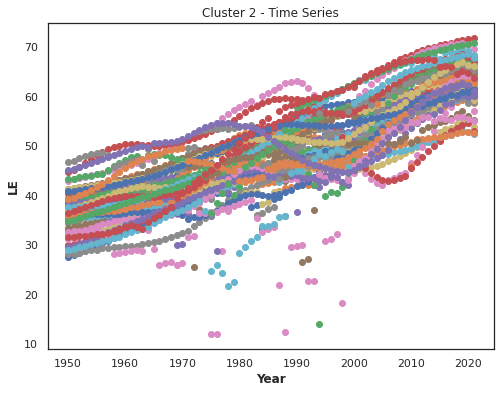

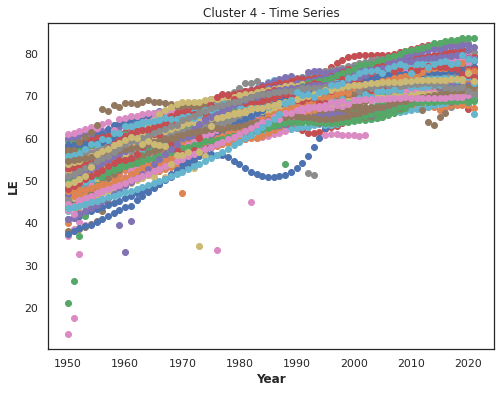

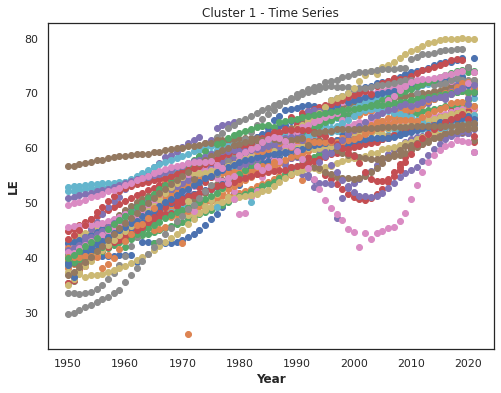

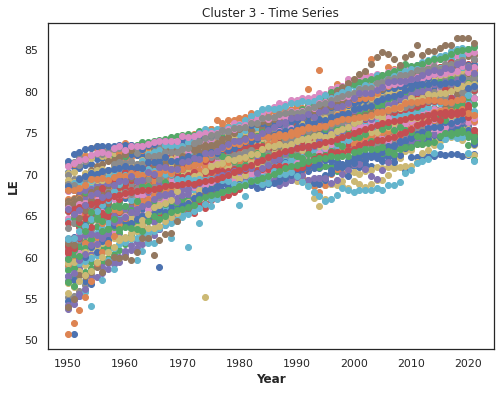

In [32]:
# Long format
np.random.seed(45)

# Pivot data differently to preserve individual time series
pivoted_data = data_countries.pivot(index='Country', columns='Year', values='LE')

# Convert the pivot data to a list of time series
time_series = pivoted_data.values.tolist()

# Build and fit the model on the list of time series
bisect_means = BisectingKMeans(n_clusters=4, bisecting_strategy="biggest_inertia").fit(time_series)

# Get the cluster labels and cluster centers
labels = bisect_means.labels_
centers = bisect_means.cluster_centers_

# Create a dictionary to store the clustered data
clustered_data = {}

# Iterate over each country and its corresponding label
for country, label in zip(pivoted_data.index, labels):
    # Check if the cluster label is already in the dictionary
    if label in clustered_data:
        # Append the country's time series and label to the existing cluster
        clustered_data[label].append((country, pivoted_data.loc[country]))
    else:
        # Create a new cluster and store the country's time series and label
        clustered_data[label] = [(country, pivoted_data.loc[country])]

# Create folder for saving the cluster files if it doesn't exist
if not os.path.exists('clustered_data'):
    os.makedirs('clustered_data')

# Save the clustered data to separate CSV files and create scatter plots
for label, data in clustered_data.items():
    # Create a list to store the long format data rows
    long_data = []

    for country, ts in data:
        # Convert date strings to datetime objects and extract the year
        years = years = [date.year for date in ts.index]

        # Append the long format data for each year to the list
        long_data.extend(zip([country]*len(years), years, ts.values))

    # Create a DataFrame from the long format data
    long_df = pd.DataFrame(long_data, columns=['Country', 'Year', 'LE'])

    # Create a file for each cluster
    filename = f"clustered_data/long_cluster_{label}_full.csv"

    # Save the long format data to a CSV file
    long_df.to_csv(filename, index=False)

    # Create a scatter plot for each cluster
    plt.figure(figsize=(8, 6))
    for _, ts in data:
        # Convert date strings to datetime objects and extract the year
        x = [date.year for date in ts.index]
        plt.scatter(x, ts.values)

    # Set x-axis ticks to display every 10 years
    x_ticks = np.arange(x[0], x[-1] + 1, 10)
    plt.xticks(x_ticks)

    plt.title(f"Cluster {label + 1} - Time Series")
    plt.xlabel("Year")
    plt.ylabel("LE")
    plt.show()


In [21]:
pivoted_data.head()

Year,1950-01-01,1951-01-01,1952-01-01,1953-01-01,1954-01-01,1955-01-01,1956-01-01,1957-01-01,1958-01-01,1959-01-01,...,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01,2021-01-01
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,27.7,28.0,28.4,28.9,29.2,29.9,30.4,30.9,31.5,32.0,...,61.9,62.4,62.5,62.7,63.1,63.0,63.1,63.6,62.6,62.0
Albania,44.7,45.1,46.0,46.5,47.6,48.5,49.6,50.7,52.0,53.2,...,78.1,78.1,78.4,78.6,78.9,79.0,79.2,79.3,77.0,76.5
Algeria,42.4,42.5,42.9,42.9,40.2,40.4,40.3,40.4,40.4,40.5,...,74.2,74.6,75.1,75.6,75.7,75.7,76.1,76.5,74.5,76.4
American Samoa,61.0,61.4,61.6,61.3,62.1,62.3,62.6,62.9,63.3,63.6,...,72.3,72.3,72.3,72.5,72.4,72.5,72.5,72.3,72.4,72.5
Andorra,64.6,64.2,67.4,68.2,69.5,69.3,69.3,69.1,71.4,71.2,...,82.9,82.9,82.9,83.0,83.0,83.0,83.0,83.0,79.0,80.4


### Number of time series in each plot

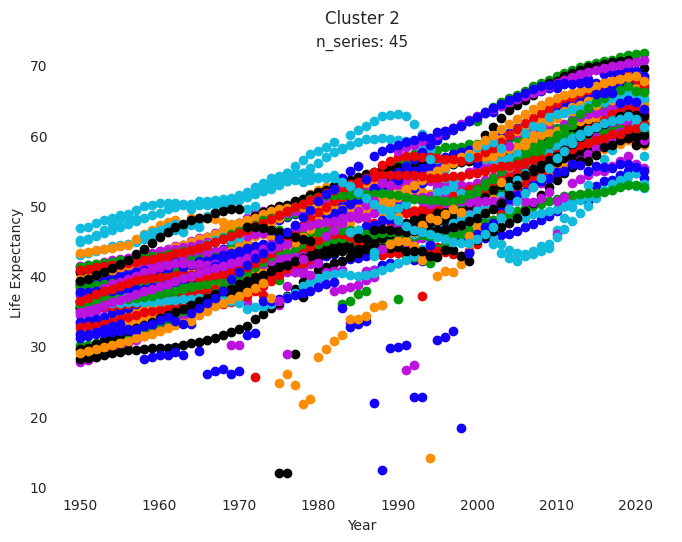

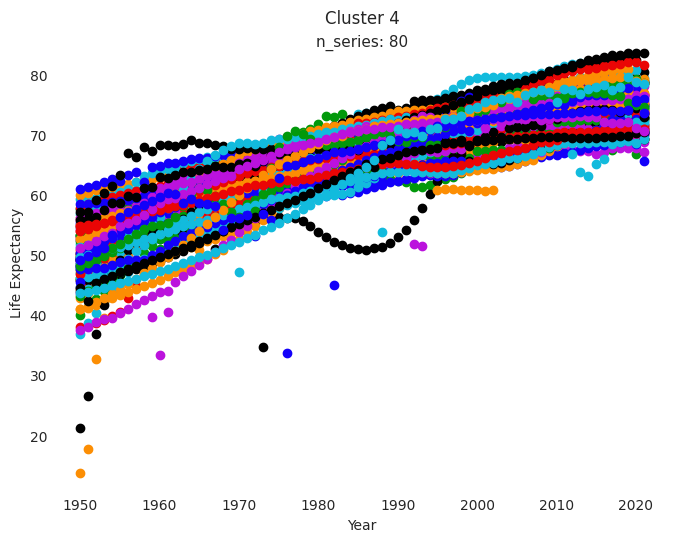

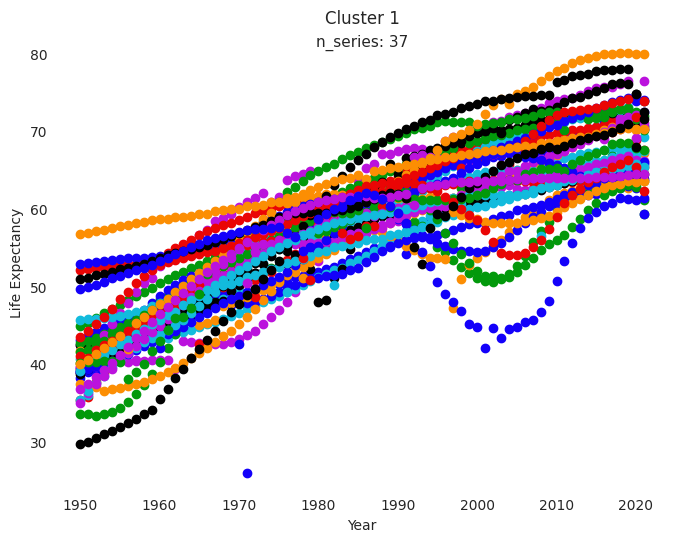

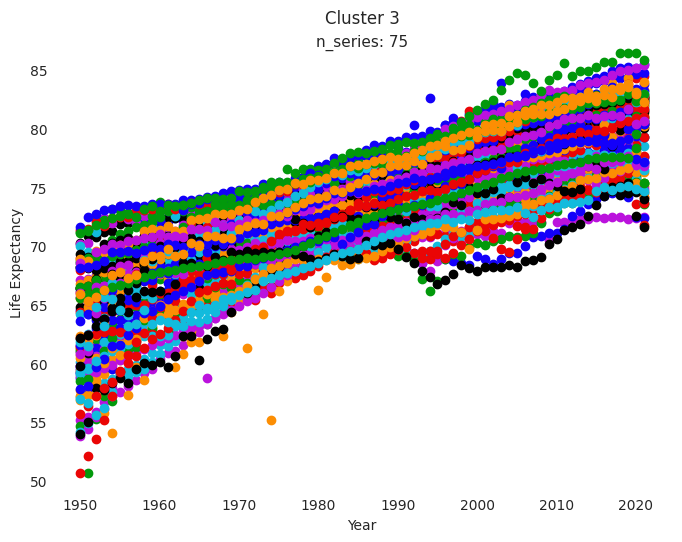

In [85]:
# Long format
np.random.seed(45)

# Pivot data differently to preserve individual time series
pivoted_data = data_countries.pivot(index='Country', columns='Year', values='LE')

# Convert the pivot data to a list of time series
time_series = pivoted_data.values.tolist()

# Build and fit the model on the list of time series
bisect_means = BisectingKMeans(n_clusters=4, bisecting_strategy="biggest_inertia").fit(time_series)

# Get the cluster labels and cluster centers
labels = bisect_means.labels_
centers = bisect_means.cluster_centers_

# Create a dictionary to store the clustered data
clustered_data = {}

# Iterate over each country and its corresponding label
for country, label in zip(pivoted_data.index, labels):
    # Check if the cluster label is already in the dictionary
    if label in clustered_data:
        # Append the country's time series and label to the existing cluster
        clustered_data[label].append((country, pivoted_data.loc[country]))
    else:
        # Create a new cluster and store the country's time series and label
        clustered_data[label] = [(country, pivoted_data.loc[country])]

# Create folder for saving the cluster files if it doesn't exist
if not os.path.exists('clustered_data'):
    os.makedirs('clustered_data')

# Save the clustered data to separate CSV files and create scatter plots
for label, data in clustered_data.items():
    # Get the number of time series in the cluster
    num_time_series = len(data)

    # Create a list to store the long format data rows
    long_data = []

    for country, ts in data:
        # Convert date strings to datetime objects and extract the year
        years = [date.year for date in ts.index]

        # Append the long format data for each year to the list
        long_data.extend(zip([country] * len(years), years, ts.values))

    # Create a DataFrame from the long format data
    long_df = pd.DataFrame(long_data, columns=['Country', 'Year', 'LE'])

    # Create a file for each cluster
    filename = f"clustered_data/long_cluster_{label}_full.csv"

    # Save the long format data to a CSV file
    long_df.to_csv(filename, index=False)

    # Create a scatter plot for each cluster
    plt.style.use('seaborn-white')  #default
    # Define your desired color palette
    custom_palette = ['#BB12DD', '#1300FA','#12BBDD', '#02990B', '#FC8E03', '#EA0505','black' ] #purple, blue, turquoise, green, orange, red, 


    # Set the custom color palette
    sns.set_palette(custom_palette)
    plt.figure(figsize=(8, 6))
    for _, ts in data:
        # Convert date strings to datetime objects and extract the year
        x = [date.year for date in ts.index]
        plt.scatter(x, ts.values)

    # Set x-axis ticks to display every 10 years
    x_ticks = np.arange(x[0], x[-1] + 1, 10)
    plt.xticks(x_ticks)

    # Get the current axes
    ax = plt.gca()

    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set the remaining spines to be white in color
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_color('white')

    # Add the subtitle with the number of time series
    subtitle = f"n_series: {num_time_series}"
    plt.title(f"Cluster {label + 1}")
    # Set the subtitle with a smaller font size
    plt.text(0.5, 0.96, subtitle, fontsize=11, ha='center', va='bottom', transform=plt.gca().transAxes)
    plt.xlabel("Year")
    plt.ylabel("Life Expectancy")
    plt.grid(False)
    plt.show()

